In [1]:
from keys import ameritrade
import requests
import time
from statistics import mean, stdev
import matplotlib.pyplot as plt
from time import sleep

In [2]:
Stock = "SPY"
TIME_PERIOD = 20
THRESHOLD = 0
# THRESHOLD = 0.1
PORTION = 0.5
endDate = "1654308000000" #US/Eastern Time: 2022-06-03 22:00:00
# endDate = "1654912800000" #US/Eastern Time: 2022-06-10 22:00:00

In [3]:
position = {
    "amount": 100,
    "average_cost": 400,
    "earning": 0
}

In [4]:
payload = {
    "apikey": ameritrade,
    "periodType": "day",
    "period": "5",
    "frequencyType": "minute",
    "frequency": "1",
    "endDate": endDate
}

In [9]:
url = "https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(Stock)
results = ''
while not results:
    try:
        results = requests.get(url, params=payload)
    except:
        sleep(5)
        print("Was a nice sleep, now let me continue...")
        continue
price, bup_price, bdown_price = [], [], []
position_amount = []

Was a nice sleep, now let me continue...
Was a nice sleep, now let me continue...


In [10]:
# function to calculate bollinger bands
def get_BBands(prices, time_period):
    prices = prices[-time_period:]
    ma = mean(prices)
    std = stdev(prices)
    bup = ma + 2*std # THRESHOLD可以加到这里
    bdown = ma - 2*std
    return bup, bdown

In [11]:
# place order
def place_order(bup, bdown, cur_price):
    if cur_price + THRESHOLD > bup:
        # place selling order
        selling_amount = position["amount"]*PORTION
        if selling_amount < 0.1:
            print("cannot sell stock at amount less than 0.1")
            return
        position["earning"] += selling_amount*(cur_price-position["average_cost"])
        position["amount"] = position["amount"]*(1-PORTION)
        print("Sell {} amount of {} at ${}".format(str(selling_amount), Stock, str(cur_price)))
        print(position["earning"])
    if cur_price - THRESHOLD < bdown:
        # place buying order
        buying_amount = position["amount"] * PORTION
        total_value = buying_amount * cur_price + position["amount"] * position["average_cost"]
        position["amount"] = position["amount"] * (1 + PORTION)
        position["average_cost"] = total_value / position["amount"]
        print("Buy {} amount of {} at ${}".format(str(buying_amount), Stock, str(cur_price)))

In [12]:
def main():
    for candle in results.json()["candles"]:
        cur_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(candle["datetime"])/1000.0))
        cur_price = (candle["low"] + candle["high"]) / 2
        price.append(cur_price)

        if len(price) >= TIME_PERIOD:
            period_price = price[-TIME_PERIOD:]
            bup, bdown = get_BBands(period_price, TIME_PERIOD)
            bup_price.append(bup)
            bdown_price.append(bdown)
            place_order(bup, bdown, cur_price)
        else:
            bup_price.append(cur_price)
            bdown_price.append(cur_price)
        position_amount.append(position["amount"])
    print(position)

    plt.plot(price, '-.')
    plt.plot(bup_price, '-g.')
    plt.plot(bdown_price, '-r.')
    # plt.plot(position_amount, '-b.')
    plt.show()


In [14]:
# final position
print(position)

{'amount': 18.44018678714287, 'average_cost': 410.4421141050937, 'earning': 8260.993794267903}


In [30]:
# print real-time position from 2022-06-03 to 2022-06-10
import pandas as pd 
import numpy as np
pd.DataFrame(np.array(([100,]*2 + position_amount)).reshape((7,660)).T, columns=[i for i in range(3,10)])

,3,4,5,6,7,8,9
0,100.000000,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793
1,100.000000,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793
2,100.000000,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793
3,100.000000,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793
4,100.000000,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793
...,...,...,...,...,...,...,...
655,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793,18.440187
656,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793,18.440187
657,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793,18.440187
658,0.142866,0.139336,0.343982,3.396782,0.472228,6.994793,18.440187


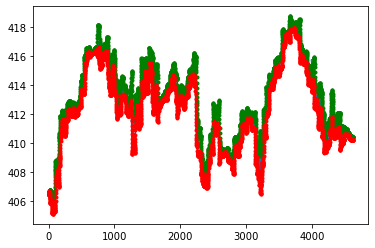

In [13]:
# print to log
import sys
old_stdout = sys.stdout
log_file = open("message.log","w")
sys.stdout = log_file

main()

sys.stdout = old_stdout
log_file.close()